In [162]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage import io, filters, morphology
from skimage.draw import polygon 
from scipy.ndimage import minimum_filter, gaussian_filter1d  # Added gaussian_filter1d import

from scipy.ndimage import generic_filter
%matplotlib widget

In [166]:
image_path = 'C:/Users/ica/OneDrive - Plymouth Marine Laboratory/vscode/whitecaps/data/Stbd_2011_06_26_22_00_00.jpg'

In [167]:
im = io.imread(image_path).astype(np.float64)
#convert pixels into numbes


In [168]:

im=im/255
im_rg = (im[:,:,0] + im[:,:,1]) / 2
im_rg.min(), im_rg.max()
#turn into grayscale (0 to 1) 


(0.11176470588235293, 0.6568627450980392)

In [169]:
   
def moving_min(block):
    '''
    np.nanmin(block): Finds the minimum value in the block, ignoring NaN values
    np.ones_like(block): Creates an array of the same shape as the input, filled with ones
    Multiplies the minimum value by an array of ones, effectively creating a block where every pixel is set to the minimum value
    '''
    return np.nanmin(block) * np.ones_like(block)

In [170]:
#applies funciton with a 50x50 block for the whole image
background = ndi.minimum_filter(im_rg, size=(25, 25)) 


In [171]:
#background_smoothed = filters.gaussian(background, sigma=10) #singma is amount of smoothing

# Subtract background
im_subtracted = im_rg - background

In [172]:
im_subtracted.min()

0.0

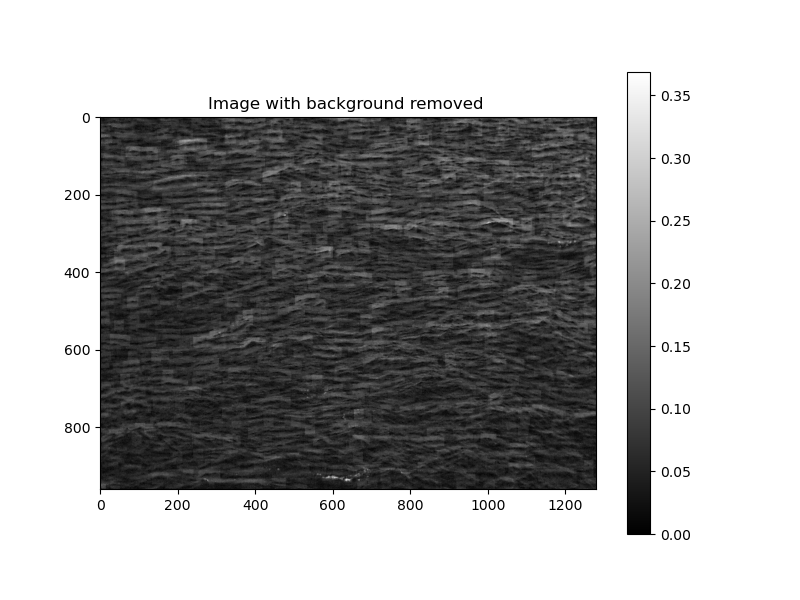

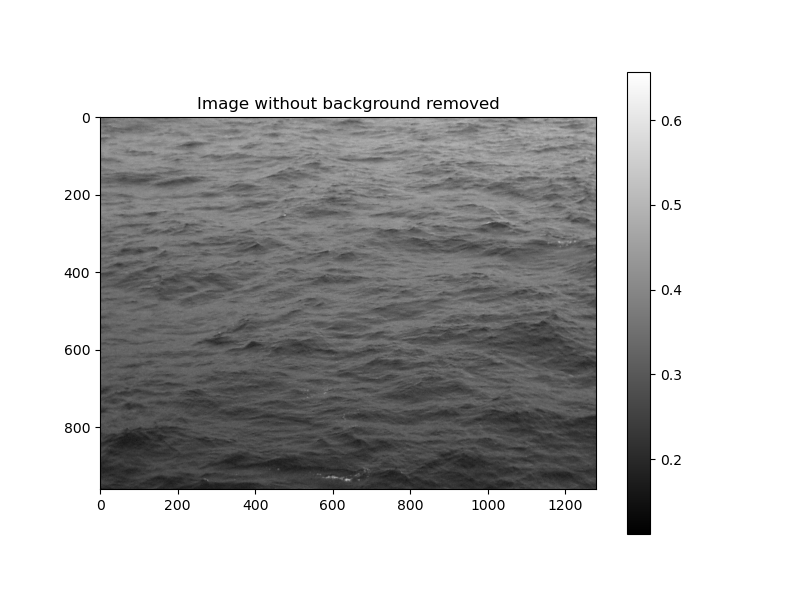

In [186]:
plt.figure(1)
plt.clf()
plt.title('Image with background removed ')
plt.imshow(im_subtracted, cmap='gray')
plt.colorbar()
plt.show()


plt.figure(2)
plt.clf()
plt.title('Image without background removed')
plt.imshow(im_rg, cmap='gray')
plt.colorbar()
plt.show()

In [175]:
intensity_vector = np.arange(0, np.nanmax(im_subtracted)*0.9, 0.01)
'''
np.nanmax(im_subtracted): Finds the maximum intensity value in the image, ignoring NaN values.
*0.9: Multiplies by 0.9 to avoid extreme outliers at the maximum intensity.
np.arange(start, stop, step): Creates a range of intensity thresholds from 0 to 90% of the max intensity with a step size of 0.01. 
'''

# Calculate the PIP
hist, bin_edges = np.histogram(im_subtracted[~np.isnan(im_subtracted)], 
                                bins=intensity_vector)

'''
Counts how many pixel intensities fall within each range (bin) defined by the intensty vector
    Excludes NaN values to ensure valid calculations.
np.histogram: Computes the histogram, returning:
hist: Counts of pixels in each bin.
bin_edges: The boundaries of the bins.
'''

# Flip to start at highest intensity threshold to lowest
hist_reversed = hist[::-1]
bin_edges_reversed = bin_edges[::-1]

# Get cumulative sum at each successively lower intensity
cumulative_sum = np.cumsum(hist_reversed)

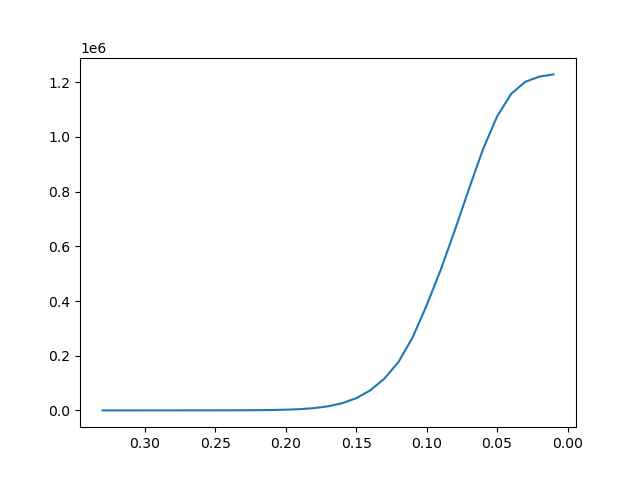

In [188]:
plt.figure()
plt.plot(bin_edges_reversed[:-1], cumulative_sum)
plt.gca().invert_xaxis()

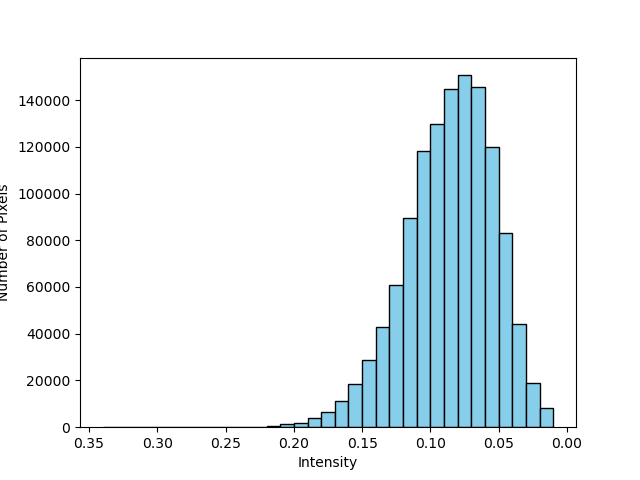

In [189]:
plt.figure()
plt.bar(bin_edges_reversed[:-1], hist_reversed, width=np.diff(bin_edges), edgecolor='black', align='edge', color='skyblue')
plt.xlabel('Intensity')
plt.ylabel('Number of Pixels')
plt.gca().invert_xaxis()
plt.show()

In [178]:
pip = np.gradient(cumulative_sum) / cumulative_sum


In [179]:
pip_IMC =  (cumulative_sum[1:] - cumulative_sum[:-1]) / cumulative_sum[1:]

In [180]:
pip.max()
pip_IMC.max()

0.4555471124620061

In [ ]:
plt.figure()
plt.plot(bin_edges_reversed[:-2], pip_IMC)
plt.xlabel('Intensity')
plt.ylabel('PIP')
plt.gca().invert_xaxis()



In [ ]:
plt.figure()
pip_smoothed =filters.gaussian(pip_IMC, sigma=5)




In [ ]:
plt.figure()
plt.plot(bin_edges_reversed[:-2], pip_smoothed)

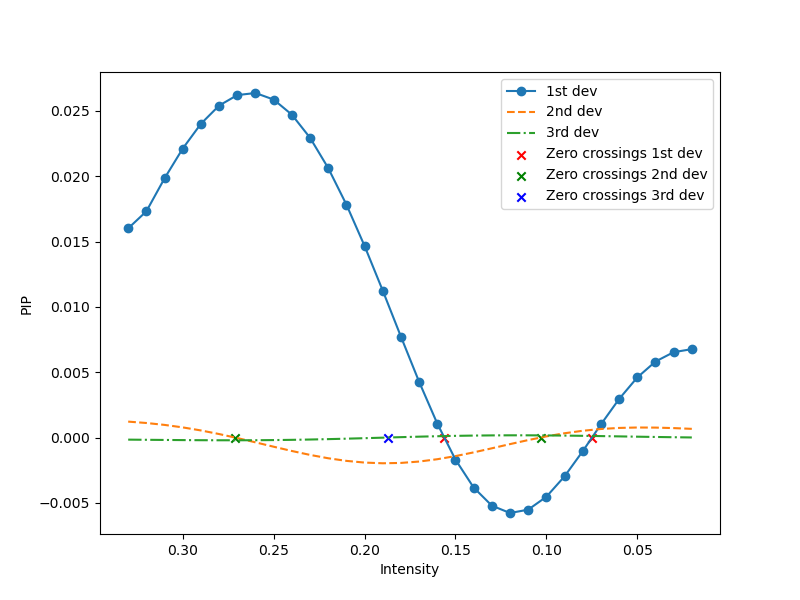

Zero crossings for pip_1: [0.15612387 0.07488568]
Zero crossings for pip_2: [0.27132754 0.10304808]
Zero crossings for pip_3: [0.18708298]


In [190]:
pip_1 = np.gradient(pip_smoothed[::-1])
pip_2 = filters.gaussian(np.gradient(pip_1), sigma=5)
pip_3 = filters.gaussian(np.gradient(pip_2), sigma=5)

# Function to find zero crossings
def find_zero_crossings(x, y):
    """Finds approximate zero crossings using linear interpolation."""
    sign_changes = np.where(np.diff(np.sign(y)))[0]  # Indices where sign changes
    zero_crossings = x[sign_changes] - y[sign_changes] * (x[sign_changes + 1] - x[sign_changes]) / (y[sign_changes + 1] - y[sign_changes])
    return zero_crossings

# Find zero crossings
zero_pip_1 = find_zero_crossings(bin_edges_reversed[:-2], pip_1)
zero_pip_2 = find_zero_crossings(bin_edges_reversed[:-2], pip_2)
zero_pip_3 = find_zero_crossings(bin_edges_reversed[:-2], pip_3)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(bin_edges_reversed[:-2], pip_1, label='1st dev ', linestyle='-', marker='o')
plt.plot(bin_edges_reversed[:-2], pip_2, label='2nd dev', linestyle='--')
plt.plot(bin_edges_reversed[:-2], pip_3, label='3rd dev', linestyle='-.')

# Plot zero crossings
plt.scatter(zero_pip_1, np.zeros_like(zero_pip_1), color='r', marker='x', label='Zero crossings 1st dev')
plt.scatter(zero_pip_2, np.zeros_like(zero_pip_2), color='g', marker='x', label='Zero crossings 2nd dev')
plt.scatter(zero_pip_3, np.zeros_like(zero_pip_3), color='b', marker='x', label='Zero crossings 3rd dev')

# Labels and legend
plt.xlabel('Intensity')
plt.ylabel('PIP')
plt.legend()
plt.gca().invert_xaxis()

# Show plot
plt.show()

# Print zero crossings
print("Zero crossings for pip_1:", zero_pip_1)
print("Zero crossings for pip_2:", zero_pip_2)
print("Zero crossings for pip_3:", zero_pip_3)

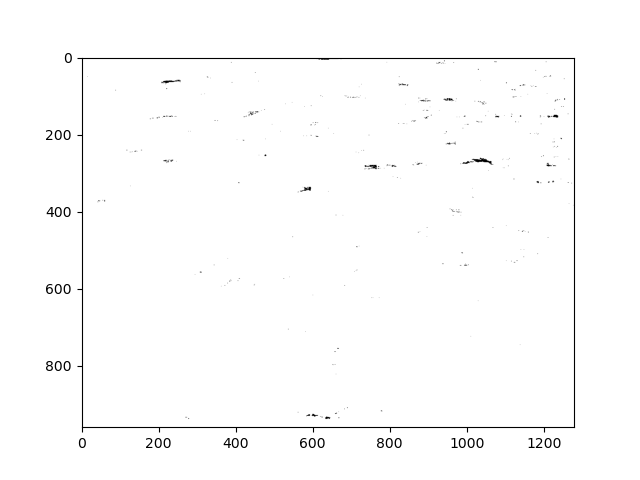

In [191]:
whitecap_mask = im_subtracted > 0.18708298
plt.figure()
plt.imshow(whitecap_mask, cmap='binary')